# Inference example for a model predicting creatinine thresholds

## Imports and utility functions

In [2]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

from strats_pytorch.datasets.dataset_int_classif import MIMIC_Int_Classif, padded_collate_fn
from strats_pytorch.models.strats import STraTS


def denorm(val, mean, std):
    return (val * std) + mean

## Model Initialization

In [3]:
exp_n = 0
exp_path = f"exp_creatinine/exp_{exp_n}/"

model = STraTS(
    n_var_embs=17,
    dim_demog=2,
    dropout=0.0,
    n_layers=2,
    dim_embed=52,
    n_heads=4,
    forecasting=False,
    n_classes=4
)
model.load_state_dict(torch.load(exp_path + "STraTS.pth"))

<All keys matched successfully>

## Dataset and Dataloader Initialization

In [5]:
test_ds = MIMIC_Int_Classif(
    data_path="generated/creat17NoText_culled.csv"
)
test_ds.restrict_to_indexes(np.load(exp_path + "test_idx.npy"))

# Variable and Time normalization
test_ds.normalize(normalize_vars=True, normalize_times=True, verbose=True)


Normalizing variables...


100% 17/17 [00:00<00:00, 104.37it/s]


Normalizing times...


  0% 0/13513 [00:00<?, ?it/s]/notebook_data/dataset.py:95: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.39671816 -1.25757053 -1.25185214 -1.25185214 -1.249946   -1.249946
 -1.249946   -1.23850921 -1.22897855 -1.22897855 -1.22897855 -1.22897855
 -1.22897855 -1.08030026 -1.08030026 -1.06886347 -1.06886347 -1.06886347
 -1.00024272 -1.00024272 -1.00024272 -1.00024272 -1.00024272 -0.88587481
 -0.88587481 -0.88587481 -0.88587481 -0.88587481 -0.88587481 -0.77150689
 -0.77150689 -0.77150689 -0.77150689 -0.77150689 -0.66857577 -0.66857577
 -0.66857577 -0.66857577 -0.65713898 -0.65713898 -0.65713898 -0.65713898
 -0.65713898 -0.54277106 -0.54277106 -0.54277106 -0.54277106 -0.54277106
 -0.42840315 -0.42840315 -0.42840315 -0.42840315 -0.42840315 -0.42840315
 -0.31403523 -0.31403523 -0.3121291  -0.3121291  -0.3121291  -0.19966732
 -0.19966732 -0.19013666 -0.16916921 -0.16916921 -0.0852994  -0.0852994
 -0.0852994  -0.0757687

In [6]:
test_dl = DataLoader(
    test_ds, 
    batch_size=1, 
    collate_fn=padded_collate_fn, 
    shuffle=False # Note: we need shuffle False to know which time_mean and time_std to use for plotting
)

## Example time series

In [17]:
# Get a single time series, of index stay_ind
# Note: we need the dataloader to generate the mask
stay_ind = 3
for ind, (demog, values, times, variables, target, mask) in enumerate(test_dl):
    if ind==stay_ind:
        break

# actual stay index just for time denormalization later when plotting
stay_ind = test_ds.indexes[stay_ind]

In [18]:
demog_unbatched = demog[0]

gender = "Male" if demog_unbatched[0] == -1 else "Female"
age = denorm(demog_unbatched[1], test_ds.age_mean, test_ds.age_std)
print(f"Demog Info: {gender}, {age} y.o.")

Demog Info: Male, 77.0 y.o.


### Plotting each variable

In [19]:
values_unbatched = values[0]
times_unbatched = times[0]
variables_unbatched = variables[0]

# Collect the values and times per variable for plotting
vals_per_var = {}
times_per_var = {}
for i, v in enumerate(variables_unbatched):
    v = v.item()
    # init if needed
    if v not in vals_per_var.keys():
        vals_per_var[v] = []
        times_per_var[v] = []

    vals_per_var[v].append(denorm(values_unbatched[i], test_ds.means[v], test_ds.stds[v]))
    times_per_var[v].append(denorm(times_unbatched[i], test_ds.time_means[stay_ind], test_ds.time_stds[stay_ind]))

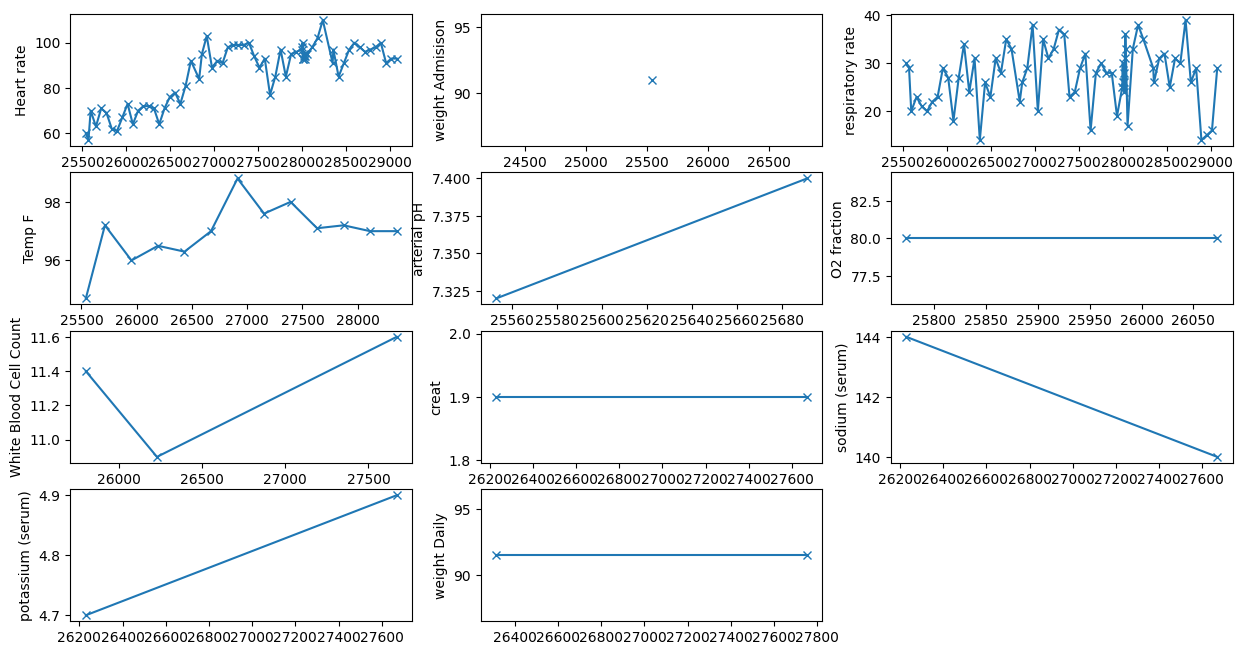

In [20]:
ind_to_var = {
    0: "creat",
    1: "Heart rate",
    2: "BP systolic",
    3: "BP diastolic",
    4: "BP mean",
    5: "Temp F",
    6: "weight Daily",
    7: "weight Admisison",
    8: "White Blood Cell Count",
    9: "sodium (serum)",
    10: "potassium (serum)",
    11: "arterial pH",
    12: "respiratory rate",
    13: "apnea interval",
    14: "minute volume",
    15: "Central Venous Pressure",
    16: "O2 fraction",
}

plt.figure(figsize=(15, 12))
for i, var_id in enumerate(times_per_var.keys()):
    plt.subplot(6, 3, i+1)
    plt.plot(times_per_var[var_id], vals_per_var[var_id], "x-")
    plt.ylabel(ind_to_var[var_id])

plt.show()

## Model prediction

In [21]:
pred = model(demog, values, times, variables, mask)
pred_label = pred.argmax().item()
print(f"Pred label: {pred_label}; Ground Truth:{int(target.item())}")

Pred label: 1; Ground Truth:1


In [24]:
variables

tensor([[ 1.,  7., 12.,  5., 11.,  1., 12.,  1., 12.,  1., 12., 11.,  1.,  5.,
         12.,  1., 12., 16.,  8.,  1., 12.,  1., 12.,  1.,  5., 12.,  1., 12.,
          1., 12., 16.,  1., 12.,  1.,  5., 12.,  0.,  8.,  9., 10.,  1., 12.,
          1.,  6., 12.,  1., 12.,  1.,  5., 12.,  1., 12.,  1., 12.,  1., 12.,
          1.,  5., 12.,  1., 12.,  1., 12., 12.,  1.,  1.,  5., 12.,  1., 12.,
          1., 12.,  1., 12.,  1.,  5., 12.,  1., 12.,  1., 12.,  1., 12.,  1.,
          5., 12.,  1., 12.,  1., 12.,  1., 12.,  1.,  5., 12.,  0.,  8.,  9.,
         10.,  1., 12.,  1.,  6., 12.,  1., 12.,  1.,  5., 12.,  1., 12.,  1.,
         12.,  1., 12.,  1., 12.,  1., 12.,  1., 12.,  1., 12.,  1., 12.,  1.,
         12.,  1., 12.,  1., 12.,  1.,  5., 12.,  1., 12.,  1., 12.,  1., 12.,
          1.,  5., 12.,  1., 12.,  1., 12.,  1., 12.,  1., 12.,  1., 12.,  1.,
         12.,  1., 12.,  1., 12.,  1., 12.,  1., 12.,  1., 12.,  1., 12.]])